# Chapter 11 - I2VIS

This is an implementation of a 2D viscous flow code. The energy equation (for temperature) is solved at the cell centers (unlike the example in the chapter 10 notebook, which is solved at the basic nodes.

In [1]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Pardiso

include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")

using PyPlot

In [6]:
# Define a function to form the energy equation left hand side and right hand side
function assemble_energy_equation_center(grid::CartesianGrid,rho::Matrix,Cp::Matrix,kThermal::Matrix,H::Matrix,Tlast::Matrix,dt)
    bcleft  = -1   # -1 = insulating, 1 = constant temp
    bcright = -1   #
    bctop   =  1
    bcbottom  = 1
    bcval = [0.0,0.0,1000.0,1000.0] # left,right,top,bottom
    
    N = grid.nx*grid.ny
    row = zeros(Int64,5*N);
    col = zeros(Int64,5*N);
    val = zeros(Float64, 5*N);
    R = zeros(Float64,N,1);
    k = 1;
    #        j-1   j     j   j+1   j+1
    #   i-1   |----kC----|----vy----|
    #         |          |          |
    #   i     kA    T   kB    T     |
    #         |          |          |
    #   i     |----kD--(i,j)--vy----|
    #         |          |          |
    #   i+1   vx    c    vx   c     vx
    #         |          |          |
    #   i+1   |----vy----|----vy----|
    
    for j in 1:grid.nx
        dxc = j>1 ? grid.x[j] - grid.x[j-1] : grid.x[j+1] - grid.x[j]
        dxp = grid.xc[j+1] - grid.xc[j]
        dxm = j>1 ? grid.xc[j]-grid.xc[j-1] : grid.xc[j+1] - grid.xc[j]
        for i in 1:grid.ny
            dyc = i>1 ? grid.y[i] - grid.y[i-1] : grid.y[i+1] - grid.y[i]
            dyp = grid.yc[i+1] - grid.yc[i]
            dym = i>1 ? grid.yc[i]-grid.yc[i-1] : grid.yc[i+1] - grid.yc[i]
            
            this_row = node_index(i,j,grid.ny);
            if i==1 # ghost nodes along top.
                row[k] = this_row
                col[k] = this_row
                val[k] = 1.0/2.0
                k+=1
                
                row[k] = this_row
                col[k] = node_index(i+1,j,grid.ny)
                val[k] = bctop/2.0
                k+=1
                
                R[this_row] = bcval[3]
            elseif j==1 # ghost nodes along left side.
                row[k] = this_row
                col[k] = this_row
                val[k] = 1.0/2.0
                k+=1
                
                row[k] = this_row
                col[k] = node_index(i,j+1,grid.ny)
                val[k] = bcleft/2.0
                k+=1
                
                R[this_row] = bcval[1]
            else            
                # kA, kB, kC, kD
                kA = 0.5*(kThermal[i-1,j-1] + kThermal[i,j-1])
                kB = 0.5*(kThermal[i,j]     + kThermal[i-1,j])
                kC = 0.5*(kThermal[i-1,j-1] + kThermal[i-1,j])
                kD = 0.5*(kThermal[i,j-1]   + kThermal[i,j])
                rho_c = 0.25*(rho[i-1,j-1] + rho[i,j-1] + rho[i-1,j] + rho[i,j])
                Cp_c = 0.25*(Cp[i-1,j-1] + Cp[i,j-1] + Cp[i-1,j] + Cp[i,j])

                # diagonal entry
                row[k] = this_row;
                col[k] = this_row;
                val[k] = (rho_c*Cp_c)/dt + kB/dxp/dxc + kA/dxm/dxc + kD/dyp/dyc + kC/dyp/dyc;
                k+=1
                # right
                row[k] = this_row;
                #col[k] = j==grid.nx ? node_index(i,2,grid.ny) : node_index(i,j+1,grid.ny);
                col[k] = j==grid.nx ? node_index(i,j,grid.ny) : node_index(i,j+1,grid.ny);
                val[k] = j==grid.nx ? bcright*kB/dxp/dxc : -kB/dxp/dxc;
                k+=1
                # left
                row[k] = this_row;
                col[k] = node_index(i,j-1,grid.ny);
                val[k] = -kA/dxm/dxc;
                k+=1
                # down (+y)
                row[k] = this_row;
                col[k] = i==grid.ny ? node_index(i,j,grid.ny) : node_index(i+1,j,grid.ny);
                val[k] = i==grid.ny ? bcbottom*kD/dyp/dyc : -kD/dyp/dyc;
                k+=1
                # up (-y)
                row[k] = this_row;
                col[k] = node_index(i-1,j,grid.ny);
                val[k] = -kC/dyp/dyc;
                k+=1
                
                R[this_row] = Tlast[i,j]*rho_c*Cp_c/dt;
                if j==grid.nx
                    R[this_row] += 2*bcval[2]*bcright*kB/dxp/dxc
                end
                if i==grid.ny
                    R[this_row] += 2*bcval[4]*bcbottom*kD/dyp/dyc
                end
            end
        end
    end
    row = @views row[1:k-1]
    col = @views col[1:k-1]
    val = @views val[1:k-1]
    L = sparse(row,col,val)
    return L,R
end

function ghost_temperature(grid::CartesianGrid,T::Matrix{Float64})
    # Define a new grid that is (ny+1)x(nx+1) and insert the ghost temperature values.
    bcleft  = -1   # -1 = insulating, 1 = constant temp
    bcright = -1   #
    bctop   =  1
    bcbottom  = 1
    bcval = [0.0,0.0,1000.0,1000.0] # left,right,top,bottom
    Tpad = Array{Float64,2}(undef,grid.ny+1,grid.nx+1)
    Tpad[1:grid.ny,1:grid.nx] = T[1:grid.ny,1:grid.nx]
    # right side first
    for i in 1:grid.ny
        if bcright == 1
             Tpad[i,grid.nx+1] = 2.0*bcval[2]-Tpad[i,grid.nx]
        elseif bcright == -1
            Tpad[i,grid.nx+1] = Tpad[i,grid.nx]
        end
    end
    # bottom
    for j in 1:grid.nx+1
        if bcbottom == 1
            Tpad[grid.ny+1,j] = 2.0*bcval[4]-Tpad[grid.ny,j]
        elseif bcbottom == -1
            Tpad[grid.ny+1,j] = Tpad[grid.ny,j]
        end
    end
    return Tpad
end

function subgrid_temperature_relaxation!(markers::Markers,grid::CartesianGrid,Tlast::Matrix,Cp,kThermal,dt::Float64)
        dsubgrid = 1.0; # subgrid temperature diffusivity
        dT_subgrid_m = Array{Float64,2}(undef,1,markers.nmark)
        # compuate the nodal temperature on the markers.    
        cell_center_to_markers!(markers,grid,Tlast,dT_subgrid_m)
    
        # compute the subgrid temperature changes on the markers
        rho = markers.scalarFields["rho"]
        T = markers.scalarFields["T"]
        Threads.@threads for i in 1:markers.nmark
            dx2 = (grid.x[markers.cell[1,i]+1] - grid.x[markers.cell[1,i]])^2
            dy2 = (grid.y[markers.cell[2,i]+1] - grid.y[markers.cell[2,i]])^2
            tdiff = markers.scalars[rho,i]*Cp/kThermal / (2/dx2 + 2/dy2)
            dT_subgrid_m[i] = (dT_subgrid_m[i]-markers.scalars[T,i])*( 1.0 - exp(-dsubgrid*dt/tdiff) )
        end
        # interpolate subgrid temperature changes back onto basic nodes.
        markers.scalars[T,1:markers.nmark] += dT_subgrid_m[1,:]
    
        return marker_to_cell_center(markers,grid,dT_subgrid_m)[1]
end

function initial_conditions!(markers::Markers)
    rho = markers.scalarFields["rho"]
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-2.5e5)^2 + (my-2.5e5)^2)^0.5
        # my initial misunderstanding of the problem setup:
        # markers.rho[i] = mx >= 200e3 && mx <= 300e3 ? 3200. : 3300.
        markers.scalars[rho,i] = mr < 1.0e5 ? 3200. : 3300.
        markers.scalars[eta,i] = mr < 1.0e5 ? 1e20 : 1e21 
        markers.scalars[T,i] = mr < 1.0e5 ? 1300. : 1000.
    end
end

function visualization(grid::CartesianGrid,rho::Matrix,eta::Matrix,vn::Array{Float64},pressure::Matrix,temperature::Matrix,time ; filename="test.vts")
    # write the visualization output from the regular grid as a .vts file.
    vtk_grid(filename, grid.x, grid.y) do vtk
        vtk["rho"] = transpose(rho)
        vtk["viscosity"] = transpose(eta)
        # add a fake third dimension to the velocity vectors
        v3 = Array{Float64,3}(undef,3,grid.nx,grid.ny)
        v3[1:2,:,:] = vn
        v3[3,:,:] .= 0.0
        vtk["Velocity"] = v3
        vtk["Temperature"] = transpose(temperature)
        vtk["pressure"] = transpose(pressure[2:end,2:end])
        vtk["TIME"] = time
    end
end

function visualization(markers::Markers,time; filename="markers.vtp")  
    p3 = Array{Float64,2}(undef,3,markers.nmark)
    p3[1:2,:] = markers.x[1:2,1:markers.nmark]
    p3[3,:] .= 0.0
      
    polys = [MeshCell(PolyData.Polys(),i:i) for i in 1:markers.nmark]
    vtk_grid(filename,p3,polys) do vtk    
        for key in keys(markers.scalarFields)
            vtk[key] = markers.scalars[markers.scalarFields[key],1:markers.nmark]
        end
       vtk["TimeValue"] = time
    end
end

visualization (generic function with 2 methods)

# i2vis procedure

0. Set up the Eulerian grid and Lagrangian markers. Distribute the markers within the domain and assign initial conditions.
1. Compute density and viscosity at the basic nodes. Compute cell center viscosity via averaging.
2. Assemble and solve the Stokes equations.
3. Compute the maximum timestep from the velocity field and CFL number.
3. Transfer temperature from markers to basic nodes.
4. Compute the new temperature solution.
5. If the maximum temperature change exceeds a specified value, reduce the timstep and repeat step 4.
6. Compute the subgrid temperature changes and update the temperature on the markers.
7. Move the markers using 2nd order Runge-Kutta

In [7]:
function run(nstep::Int64)
    nx = 201
    ny = 201
    W = 5e5
    H = 5e5
    gx = 0.0
    gy = 10.0

    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.

    markx = 5
    marky = 5
    seconds_in_year = 3.15e7
    plot_interval = 1e5*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);
    Cp = 1250. .* ones(grid.ny,grid.nx);
    H = zeros(grid.ny,grid.nx);
    # fill!(rho,3200.);
    # fill!(kThermal,3.0);
    # fill!(Cp,1000.);

    time = 0.0
    iout=0
    last_plot = 0.0


    local rho
    local eta_s
    local T
    local dt
    local dTmax
    local dTemp
    local Tnew
    local Tlast

    output_dir = "ch11_subgrid"
    for itime in 1:nstep
        # Get density and viscosity from the markers.
        rho_new,eta_s_new = marker_to_basic_node(markers,grid,["rho","eta"]);

        if time > 0.0
            nanind = findall(isnan.(rho_new))
            rho_new[nanind] = rho[nanind]
            eta_s_new[nanind] = eta_s[nanind]     
        end

        rho   = copy(rho_new)
        eta_s = copy(eta_s_new) 

        eta_n = viscosity_to_cell_centers(grid,eta_s_new)

        # assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s_new,eta_n,rho_new,bc,gx,gy)
        solution = L\R
        vx,vy,P = unpack(solution,grid;ghost=true)
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        dt = compute_timestep(grid,vxc,vyc;dtmax=dtmax)

        # get temperature at cell centers
        Tlast, = marker_to_cell_center(markers,grid,["T",])
        Tlast = ghost_temperature(grid,Tlast);
        if time > 0.0
            nanind = findall(isnan.(Tlast))
            Tlast[nanind] = T[nanind]
        end

        dTmax = Inf
        while dTmax >= 20.0 # limit maximum temperature change
            # assemble and solve the energy equation
            println("Trying with timestep ",dt)
            L,R = assemble_energy_equation_center(grid,rho,Cp,kThermal,H,Tlast,dt);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature(grid,Tnew);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            println("dTmax=",dTmax," dt=",dt)
            dt = min(dt,dTmax < 20.0 ? dt : dt/2)
        end

        dT_subgrid_node = subgrid_temperature_relaxation!(markers,grid,Tlast,Cp[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node
    #     dT_remaining = dTemp
        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        if time == 0.0 || time - last_plot >= plot_interval
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1


    #         figure()
    #         plot(grid.xc,Tnew[5,:])
    #         show()
        end

        move_markers_rk2!(markers,grid,vxc,vyc,dt)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
    end
end
@time run(500)

Creating Markers...
  0.006434 seconds (19 allocations: 55.869 MiB)
Initial condition...
  0.014722 seconds
Trying with timestep 4.291885118492122e11
dTmax=11.287766312514805 dt=4.291885118492122e11
Finished Step 1 time=0.013625032122197213 Myr
Trying with timestep 4.2945863951413885e11
dTmax=10.547012636523277 dt=4.2945863951413885e11
Finished Step 2 time=0.027258639725820672 Myr
Trying with timestep 4.294676169291358e11
dTmax=9.090424577270596 dt=4.294676169291358e11
Finished Step 3 time=0.04089253232674561 Myr
Trying with timestep 4.2925759475185657e11
dTmax=7.9207088380992445 dt=4.2925759475185657e11
Finished Step 4 time=0.054519757556963276 Myr
Trying with timestep 4.293051608534658e11
dTmax=7.1521979766794175 dt=4.293051608534658e11
Finished Step 5 time=0.06814849282215267 Myr
Trying with timestep 4.2933649628092944e11
dTmax=6.418453726005055 dt=4.2933649628092944e11
Finished Step 6 time=0.08177822286281708 Myr
Trying with timestep 4.291078292268891e11
dTmax=5.69297354012474 dt=4

Trying with timestep 4.2418891389453204e11
dTmax=0.92067062410365 dt=4.2418891389453204e11
Finished Step 75 time=1.0132478115899792 Myr
Trying with timestep 4.244282077163267e11
dTmax=0.9178770360367707 dt=4.244282077163267e11
Finished Step 76 time=1.0267217229460532 Myr
Trying with timestep 4.245445797664313e11
dTmax=0.935194042061994 dt=4.245445797664313e11
Finished Step 77 time=1.0401993286529239 Myr
Trying with timestep 4.2472497116095044e11
dTmax=0.927520214074093 dt=4.2472497116095044e11
Finished Step 78 time=1.053682661070732 Myr
Trying with timestep 4.250639381814465e11
dTmax=0.9108038456843133 dt=4.250639381814465e11
Finished Step 79 time=1.0671767543463335 Myr
Trying with timestep 4.253757345959888e11
dTmax=0.9370113186778326 dt=4.253757345959888e11
Finished Step 80 time=1.0806807459208092 Myr
Trying with timestep 4.256154953598304e11
dTmax=0.9169735019534073 dt=4.256154953598304e11
Finished Step 81 time=1.0941923489481056 Myr
Trying with timestep 4.258450800874719e11
dTmax=0

Trying with timestep 5.22875395902304e11
dTmax=1.085951391712797 dt=5.22875395902304e11
Finished Step 150 time=2.0991685931268886 Myr
Trying with timestep 5.260714668583491e11
dTmax=1.1589415304877093 dt=5.260714668583491e11
Finished Step 151 time=2.115869274614455 Myr
Trying with timestep 5.294874909944876e11
dTmax=1.1873833928486874 dt=5.294874909944876e11
Finished Step 152 time=2.132678401312693 Myr
Trying with timestep 5.3278632747207056e11
dTmax=1.1772757968922178 dt=5.3278632747207056e11
Finished Step 153 time=2.149592252978473 Myr
Trying with timestep 5.361094500558117e11
dTmax=1.1340526972592215 dt=5.361094500558117e11
Finished Step 154 time=2.166611600599292 Myr
Trying with timestep 5.397075917736376e11
dTmax=1.1287385437992725 dt=5.397075917736376e11
Finished Step 155 time=2.1837451749413126 Myr
Trying with timestep 5.432672673468911e11
dTmax=1.1083559660823994 dt=5.432672673468911e11
Finished Step 156 time=2.200991754857087 Myr
Trying with timestep 5.473713431250467e11
dTmax

Finished Step 225 time=3.6746651248272766 Myr
Trying with timestep 7.65387100357148e11
dTmax=9.53979410649913 dt=7.65387100357148e11
Finished Step 226 time=3.6989631280132174 Myr
Trying with timestep 7.737137373639095e11
dTmax=9.401613897982315 dt=7.737137373639095e11
Finished Step 227 time=3.7235254688819124 Myr
Trying with timestep 7.72350923616464e11
dTmax=9.273291536605484 dt=7.72350923616464e11
Finished Step 228 time=3.748044545822118 Myr
Trying with timestep 7.8097509193608e11
dTmax=8.810119087735984 dt=7.8097509193608e11
Finished Step 229 time=3.772837405883581 Myr
Trying with timestep 7.836483173077689e11
dTmax=8.343520787584339 dt=7.836483173077689e11
Finished Step 230 time=3.797715130242558 Myr
Trying with timestep 7.888034183463904e11
dTmax=7.875628812357945 dt=7.888034183463904e11
Finished Step 231 time=3.8227565086027604 Myr
Trying with timestep 7.935097650655778e11
dTmax=7.370680816148024 dt=7.935097650655778e11
Finished Step 232 time=3.8479472947953184 Myr
Trying with ti

dTmax=14.488119447735926 dt=5.6792341850473e11
Finished Step 288 time=5.237310862574073 Myr
Trying with timestep 1.1415638915359072e12
dTmax=23.36150477382239 dt=1.1415638915359072e12
Trying with timestep 5.707819457679536e11
dTmax=14.49038764787997 dt=5.707819457679536e11
Finished Step 289 time=5.255430924344485 Myr
Trying with timestep 1.1480639492308462e12
dTmax=23.316961386806724 dt=1.1480639492308462e12
Trying with timestep 5.740319746154231e11
dTmax=14.49592252942466 dt=5.740319746154231e11
Finished Step 290 time=5.273654161633864 Myr
Trying with timestep 1.154170863393905e12
dTmax=23.26804528974594 dt=1.154170863393905e12
Trying with timestep 5.770854316969525e11
dTmax=14.499084457166191 dt=5.770854316969525e11
Finished Step 291 time=5.291974334068688 Myr
Trying with timestep 1.159092649432749e12
dTmax=23.22615056047016 dt=1.159092649432749e12
Trying with timestep 5.795463247163745e11
dTmax=14.507104167194257 dt=5.795463247163745e11
Finished Step 292 time=5.31037263009143 Myr
Tr

dTmax=17.927259578763824 dt=7.273533803123508e11
Finished Step 333 time=6.154723029491524 Myr
Trying with timestep 1.4616474280380857e12
dTmax=27.586735056723683 dt=1.4616474280380857e12
Trying with timestep 7.308237140190428e11
dTmax=17.42758404096776 dt=7.308237140190428e11
Finished Step 334 time=6.1779237823175235 Myr
Trying with timestep 1.4687259709465637e12
dTmax=27.02934742950788 dt=1.4687259709465637e12
Trying with timestep 7.343629854732819e11
dTmax=17.036294305704814 dt=7.343629854732819e11
Finished Step 335 time=6.2012368929674695 Myr
Trying with timestep 1.4781390717645361e12
dTmax=26.570048569579285 dt=1.4781390717645361e12
Trying with timestep 7.390695358822681e11
dTmax=17.594528590664936 dt=7.390695358822681e11
Finished Step 336 time=6.2246994179161135 Myr
Trying with timestep 1.4885903414391577e12
dTmax=28.39458395912459 dt=1.4885903414391577e12
Trying with timestep 7.442951707195789e11
dTmax=18.886490824678617 dt=7.442951707195789e11
Finished Step 337 time=6.2483278360

Trying with timestep 1.7084875544989e12
dTmax=32.17100208520969 dt=1.7084875544989e12
Trying with timestep 8.5424377724945e11
dTmax=21.08386100570715 dt=8.5424377724945e11
Trying with timestep 4.27121888624725e11
dTmax=12.576861846590873 dt=4.27121888624725e11
Finished Step 369 time=6.7426625370945334 Myr
Trying with timestep 1.7139992407099604e12
dTmax=32.026973024856034 dt=1.7139992407099604e12
Trying with timestep 8.569996203549802e11
dTmax=21.01355060262358 dt=8.569996203549802e11
Trying with timestep 4.284998101774901e11
dTmax=12.54578594141617 dt=4.284998101774901e11
Finished Step 370 time=6.756265705671598 Myr
Trying with timestep 1.7197507031431316e12
dTmax=31.872841495077864 dt=1.7197507031431316e12
Trying with timestep 8.598753515715658e11
dTmax=20.937135055394492 dt=8.598753515715658e11
Trying with timestep 4.299376757857829e11
dTmax=12.511305194020451 dt=4.299376757857829e11
Finished Step 371 time=6.769914520775908 Myr
Trying with timestep 1.726262504949957e12
dTmax=31.7143

Trying with timestep 9.679113721172722e11
dTmax=23.203576515013992 dt=9.679113721172722e11
Trying with timestep 4.839556860586361e11
dTmax=13.735386383097875 dt=4.839556860586361e11
Finished Step 401 time=7.205413200516397 Myr
Trying with timestep 1.9387795146080798e12
dTmax=36.05148894834451 dt=1.9387795146080798e12
Trying with timestep 9.693897573040399e11
dTmax=23.309435462466126 dt=9.693897573040399e11
Trying with timestep 4.8469487865201996e11
dTmax=13.802167638326182 dt=4.8469487865201996e11
Finished Step 402 time=7.220800339521223 Myr
Trying with timestep 1.9455680128733486e12
dTmax=36.287819027907744 dt=1.9455680128733486e12
Trying with timestep 9.727840064366743e11
dTmax=23.479220334839056 dt=9.727840064366743e11
Trying with timestep 4.8639200321833716e11
dTmax=13.910565288254702 dt=4.8639200321833716e11
Finished Step 403 time=7.236241355496408 Myr
Trying with timestep 1.9550273398817178e12
dTmax=36.28355340142548 dt=1.9550273398817178e12
Trying with timestep 9.775136699408589

dTmax=38.17843632000927 dt=2.1824060381164636e12
Trying with timestep 1.0912030190582318e12
dTmax=25.112853855664753 dt=1.0912030190582318e12
Trying with timestep 5.456015095291159e11
dTmax=15.084829635017059 dt=5.456015095291159e11
Finished Step 433 time=7.728523059475147 Myr
Trying with timestep 2.201691778650254e12
dTmax=38.27375008335389 dt=2.201691778650254e12
Trying with timestep 1.100845889325127e12
dTmax=25.20396629398101 dt=1.100845889325127e12
Trying with timestep 5.504229446625635e11
dTmax=15.154264128785826 dt=5.504229446625635e11
Finished Step 434 time=7.745996803750148 Myr
Trying with timestep 2.222860929319944e12
dTmax=38.434479693236426 dt=2.222860929319944e12
Trying with timestep 1.111430464659972e12
dTmax=25.34329663606104 dt=1.111430464659972e12
Trying with timestep 5.55715232329986e11
dTmax=15.255286824528866 dt=5.55715232329986e11
Finished Step 435 time=7.763638557157449 Myr
Trying with timestep 2.2404716193115513e12
dTmax=38.7446089437226 dt=2.2404716193115513e12


Trying with timestep 1.268963537205889e12
dTmax=26.51565192118983 dt=1.268963537205889e12
Trying with timestep 6.344817686029445e11
dTmax=16.229025341475108 dt=6.344817686029445e11
Finished Step 465 time=8.327844239568355 Myr
Trying with timestep 2.5626093576474507e12
dTmax=39.58210471077541 dt=2.5626093576474507e12
Trying with timestep 1.2813046788237253e12
dTmax=26.6427210445936 dt=1.2813046788237253e12
Trying with timestep 6.406523394118627e11
dTmax=16.327342996618427 dt=6.406523394118627e11
Finished Step 466 time=8.348182409073493 Myr
Trying with timestep 2.5891492650428687e12
dTmax=39.695804445297654 dt=2.5891492650428687e12
Trying with timestep 1.2945746325214343e12
dTmax=26.7582911401596 dt=1.2945746325214343e12
Trying with timestep 6.472873162607172e11
dTmax=16.419523502944912 dt=6.472873162607172e11
Finished Step 467 time=8.36873121276431 Myr
Trying with timestep 2.5904933966766006e12
dTmax=39.61055277137348 dt=2.5904933966766006e12
Trying with timestep 1.2952466983383003e12
d

Trying with timestep 7.372044954811095e11
dTmax=16.970948452349376 dt=7.372044954811095e11
Finished Step 497 time=9.030787493836952 Myr
Trying with timestep 2.95758374472403e12
dTmax=39.34743295884823 dt=2.95758374472403e12
Trying with timestep 1.478791872362015e12
dTmax=27.045604454505337 dt=1.478791872362015e12
Trying with timestep 7.393959361810074e11
dTmax=16.891601604155312 dt=7.393959361810074e11
Finished Step 498 time=9.05426038069984 Myr
Trying with timestep 2.9661796524168364e12
dTmax=39.15027011371444 dt=2.9661796524168364e12
Trying with timestep 1.4830898262084182e12
dTmax=26.915213874546453 dt=1.4830898262084182e12
Trying with timestep 7.415449131042091e11
dTmax=16.813604746521833 dt=7.415449131042091e11
Finished Step 499 time=9.077801489052355 Myr
Trying with timestep 2.974579003725121e12
dTmax=39.1856845414618 dt=2.974579003725121e12
Trying with timestep 1.4872895018625605e12
dTmax=26.95522371083939 dt=1.4872895018625605e12
Trying with timestep 7.436447509312803e11
dTmax=

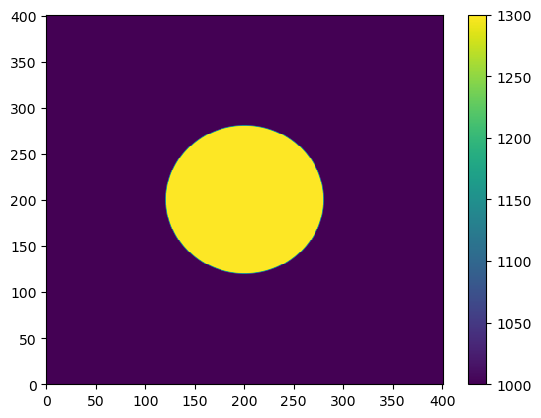

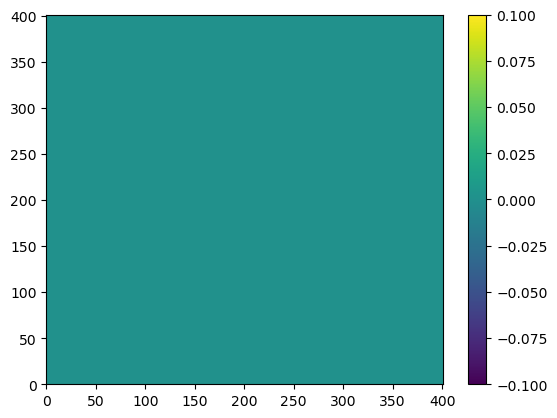

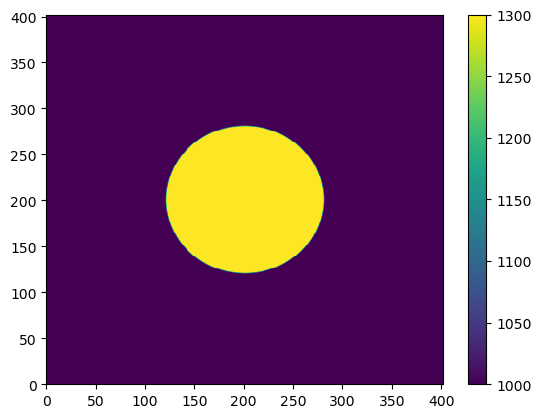

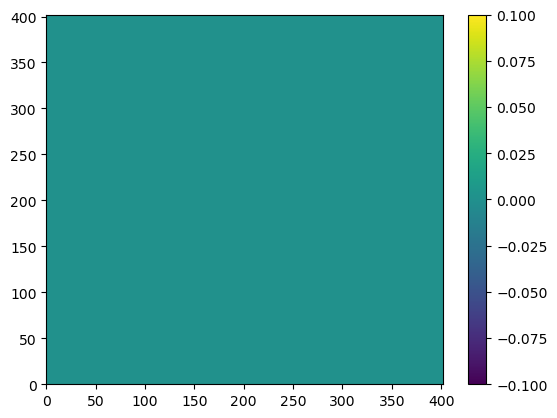

Creating Markers...
Initial condition...
  0.596479 seconds (14 allocations: 127.589 MiB, 21.93% gc time)
  0.566146 seconds (15 allocations: 127.589 MiB, 19.25% gc time)
  0.553330 seconds (14 allocations: 127.614 MiB)
  0.616950 seconds (15 allocations: 127.614 MiB, 13.00% gc time)


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/maxrudolph/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [4]:
# NOTE - this code was for testing marker interpolation routine optimizations.
include("Markers.jl")
nx = 401
ny = nx
markx=10
marky=10
W = 5e5
H = 5e5

bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.

grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=false)
println("Initial condition...")
initial_conditions!(markers)

tmp1, = marker_to_basic_node( markers,grid,markers.scalars[1:1,:])
@time tmp1, = marker_to_basic_node( markers,grid,markers.scalars[1:1,:])
tmp2, = marker_to_basic_node( markers,grid,["T",])
@time tmp2, = marker_to_basic_node( markers,grid,["T",])

figure()
pcolormesh(tmp1)
colorbar()
show()

figure()
pcolormesh(tmp2-tmp1)
colorbar()
show()


tmp1, = marker_to_cell_center( markers,grid,markers.scalars[1:1,:])
@time tmp1, = marker_to_cell_center( markers,grid,markers.scalars[1:1,:])

tmp2, = marker_to_cell_center( markers,grid,["T",])
@time tmp2, = marker_to_cell_center( markers,grid,["T",])

figure()
pcolormesh(tmp1)
colorbar()
show()

figure()
pcolormesh(tmp2-tmp1)
colorbar()
show()

# Timing/Performance

The cell below runs a single timestep at a specified resolution. It was useful for figuring out why certain parts of the code were extremely slow. It was also extremely helpful to use Julia's Profile.jl package to profile specifiec subroutines.

In [8]:
function single_timestep(ny,nx)
    W = 5e5
    H = 5e5
    gx = 0.0
    gy = 10.0
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    markx = 5
    marky = 5
    seconds_in_year = 3.15e7
    plot_interval = 1e5*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);
    Cp = 1250. .* ones(grid.ny,grid.nx);
    H = zeros(grid.ny,grid.nx);

    time = 0.0
    iout=0
    # Get density and viscosity from the markers.
    println("Marker -> basic nodes")
    @time rho_new, eta_s_new = marker_to_basic_node(markers,grid,["rho","eta"]);
    
    if time > 0.0
        nanind = findall(isnan.(rho_new))
        rho_new[nanind] = rho[nanind]
        eta_s_new[nanind] = eta_s[nanind]     
    end
    
    global rho   = copy(rho_new)
    global eta_s = copy(eta_s_new)
    println("Viscosity basic nodes -> cell centers")
    @time eta_n = viscosity_to_cell_centers(grid,eta_s_new)

    # assemble and solve the stokes equations
    println("Form Stokes")
    @time L,R = form_stokes(grid,eta_s_new,eta_n,rho_new,bc,gx,gy)
    println("Solve Stokes")
    @time solution = L\R
    
    vx,vy,P = unpack(solution,grid;ghost=true)
    vxc,vyc = velocity_to_centers(grid,vx,vy)
    dt = compute_timestep(grid,vxc,vyc;dtmax=dtmax)
    
    # get temperature at cell centers
    println("Temperature to cell centers")

    @time Tlast, = marker_to_cell_center(markers,grid,["T",])
    if time > 0.0
        
    end
    Tlast = ghost_temperature(grid,Tlast);

    # assemble and solve the energy equation
    println("Assemble T")
    @time L,R = assemble_energy_equation_center(grid,rho,Cp,kThermal,H,Tlast,dt);
    println("Solve T")
    @time Tnew = L\R;
    Tnew = reshape(Tnew,grid.ny,grid.nx);
    println("Ghost temperature values")
    @time Tnew = ghost_temperature(grid,Tnew);
    
    dTemp = Tnew-Tlast
    println("Subgrid temp relaxation")
    @time dT_subgrid_node = subgrid_temperature_relaxation!(markers,grid,Tlast,Cp[1,1],kThermal[1,1],dt)
    dT_remaining = dTemp - dT_subgrid_node
    println("Cell center change to markers")
    @time cell_center_change_to_markers!(markers,grid,dT_remaining,"T")
    
    # if time == 0.0 || time - last_plot >= plot_interval
    #     last_plot = time 
    #     name = @sprintf("output_chapter11/viz.%04d.vtr",iout)
    #     eta_s = zeros(grid.ny,grid.nx)
    #     vn = velocity_to_basic_nodes(grid,vxc,vyc)

    #     visualization(grid,rho,eta_s,vn,P,Tnew,time/seconds_in_year;filename=name)
    #     name = @sprintf("output_chapter11/markers.%04d.vtp",iout)
    #     visualization(markers,time/seconds_in_year;filename=name)
    #     iout += 1
    # end
    println("Move markers")
    @time move_markers_rk2!(markers,grid,vxc,vyc,dt)
    return markers,grid,vxc,vyc,dt
    time += dt
end

@time markers,grid,vxc,vyc,dt = single_timestep(401,401)
@time move_markers_rk2!(markers,grid,vxc,vyc,dt)

Creating Markers...
Initial condition...
  0.101387 seconds
Marker -> basic nodes
  0.146454 seconds (19 allocations: 69.929 MiB)
Viscosity basic nodes -> cell centers
  0.003369 seconds (2 allocations: 1.227 MiB)
Form Stokes
  0.183560 seconds (34 allocations: 245.760 MiB)
Solve Stokes
 10.707484 seconds (71 allocations: 2.000 GiB, 0.20% gc time)
Temperature to cell centers
  0.164398 seconds (15 allocations: 35.603 MiB)
Assemble T
  0.032837 seconds (32 allocations: 47.762 MiB)
Solve T
  1.171412 seconds (73 allocations: 276.453 MiB)
Ghost temperature values
  0.000475 seconds (5 allocations: 2.460 MiB)
Subgrid temp relaxation
  0.569266 seconds (43 allocations: 127.004 MiB)
Cell center change to markers
  0.313203 seconds (10 allocations: 784 bytes)
Move markers
  0.682872 seconds (34 allocations: 244.449 MiB, 39.48% gc time)
 14.200417 seconds (1.12 k allocations: 3.262 GiB, 2.22% gc time)
  0.443221 seconds (30 allocations: 244.448 MiB)
